In [1]:
import numpy as np
#setup camera with a simple camera matrix P
f = 100
cx = 200
cy = 200
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
I = np.eye(3) #i.e., R
t = np.array([[0], [0], [0]])
P = np.dot(K, np.hstack((I, t)))

In [2]:
def project(P, X): #X is an array of 3D points
    x = np.dot(P, X)
    for i in range(3): #convert to inhomogeneous coordinates
        x[i] /= x[2]
    return x

In [3]:
#load data
points_3D = np.loadtxt('Resources_6.1/house.p3d').T #T means tranpose
points_3D = np.vstack((points_3D, np.ones(points_3D.shape[1])))

C:\Users\shane\AppData\Local\Temp\ipykernel_17908\3712729525.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = "3d")


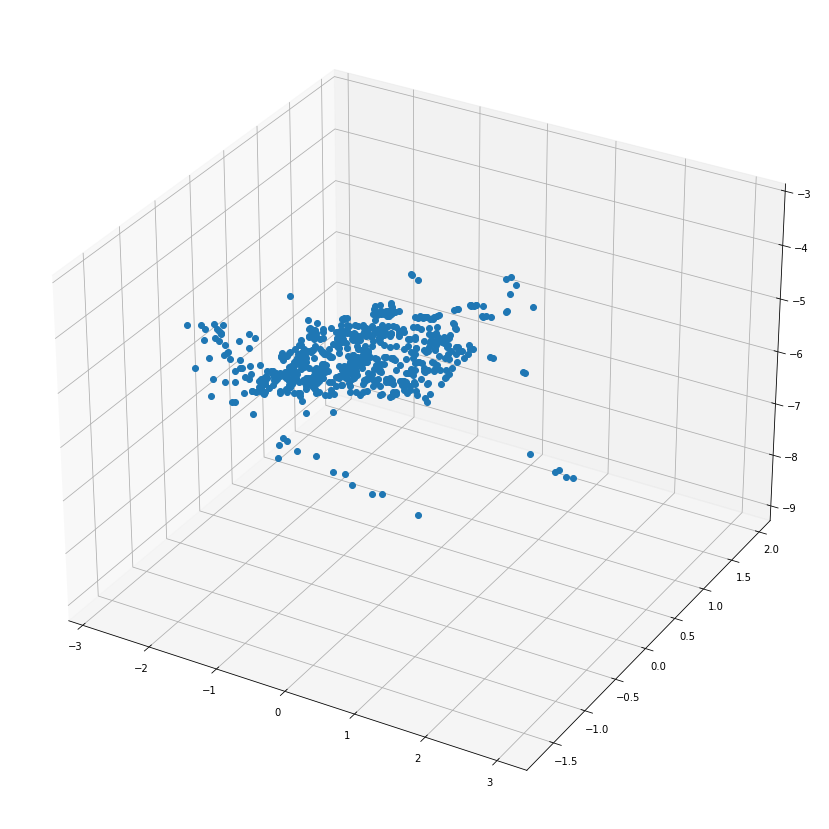

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize = [15,15])
ax = fig.gca(projection = "3d")
ax.view_init(elev = None, azim = None) #you can set elevation and azimuth with different values
ax.plot(points_3D[0], points_3D[1], points_3D[2], 'o')
plt.draw()
plt.show()

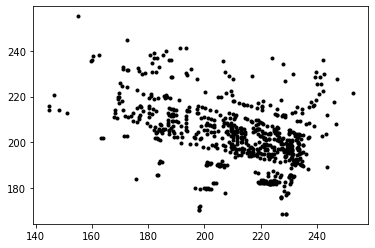

In [5]:
#projection
points_2D = project(P, points_3D)
#plot projection
from matplotlib import pyplot as plt
plt.plot(points_2D[0], points_2D[1], 'k.')
plt.show()

In [6]:
print(points_2D.shape)
print(points_3D.shape)

(3, 672)
(4, 672)


In [7]:
n_points = 6
points_3D_sampled = points_3D[:,:n_points]
points_2D_sampled = points_2D[:,:n_points]

In [8]:
A = np.zeros((2*n_points, 12), np.float32)
for i in range(n_points):
    A[2*i,:4] = points_3D_sampled[:,i].T
    A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T
    A[2*i+1,4:8] = points_3D_sampled[:,i].T
    A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T

In [9]:
from scipy import linalg
#p = linalg.solve(A, np.zeros((12, 1), np.float32))
#print(p)

In [10]:
U, S, V = linalg.svd(A)

In [11]:
minS = np.min(S)
conditon = (S == minS)
minID = np.where(conditon)
print('index of the smallest singular value is: ', minID[0])

index of the smallest singular value is:  [11]


In [12]:
P_hat = V[minID[0],:].reshape(3, 4) / minS

In [13]:
print(P)
print(P_hat)

[[100.   0. 200.   0.]
 [  0. 100. 200.   0.]
 [  0.   0.   1.   0.]]
[[ 9.3289719e+04 -4.0221130e+02  1.8646670e+05 -2.8556070e+01]
 [ 3.6980091e+01  9.2909969e+04  1.8644198e+05 -1.8464259e+02]
 [ 9.3261771e-02 -1.7817017e+00  9.3240582e+02  6.0331091e-02]]


In [14]:
x_P_hat = project(P_hat, points_3D_sampled[:, 0])
print(x_P_hat)

[225.25317749 181.44376362   1.        ]


In [15]:
x_P = points_2D_sampled[:,0]
print(x_P)

[225.25322768 181.44331296   1.        ]


In [16]:
x_P = points_2D
x_P_hat = project(P_hat, points_3D)
dist = 0
for i in range(x_P.shape[1]):
 dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i])
dist /= x_P.shape[1]
print(dist)

0.01231894491141471


### 3D Reconstruction 

In [17]:
import homography 
import sfm
import ransac

Number of detected keypoints in img1: 25477
Number of detected keypoints in img2: 24552


(-0.5, 3871.5, 1295.5, -0.5)

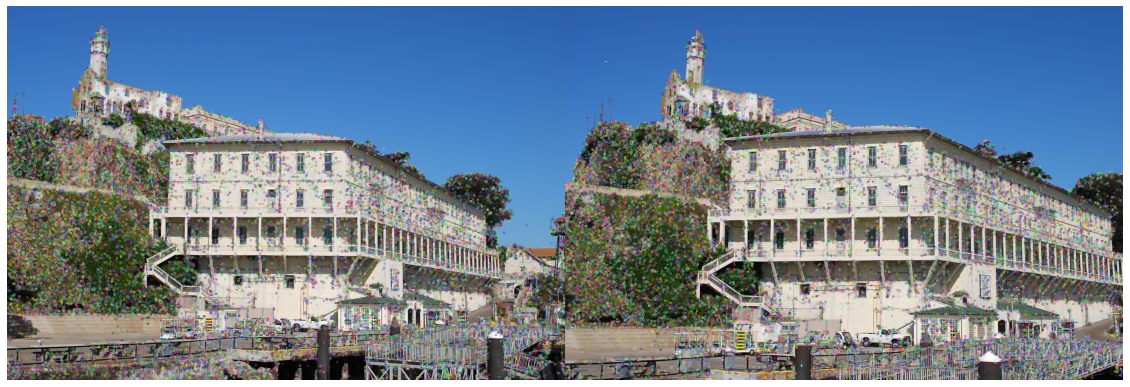

In [18]:
import cv2 as cv
sift = cv.xfeatures2d.SIFT_create()
img1 = cv.imread('Resources_6.1/alcatraz1.jpg')
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(img1_gray, None)
img2 = cv.imread('Resources_6.1/alcatraz2.jpg')
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(img2_gray, None)
img1_kp = img1.copy()
img1_kp = cv.drawKeypoints(img1, kp1, img1_kp)
print("Number of detected keypoints in img1: %d" % (len(kp1)))
img2_kp = img2.copy()
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp)
print("Number of detected keypoints in img2: %d" % (len(kp2)))
img1_2_kp = np.hstack((img1_kp, img2_kp))
plt.figure(figsize = (20, 10))
plt.imshow(img1_2_kp[:,:,::-1])
plt.axis('off')

In [19]:
bf = cv.BFMatcher(crossCheck = True) #crossCheck = True means we want to find consistent matches
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
print("Number of consistent matches: %d" % len(matches))

Number of consistent matches: 9690


(-0.5, 3871.5, 1295.5, -0.5)

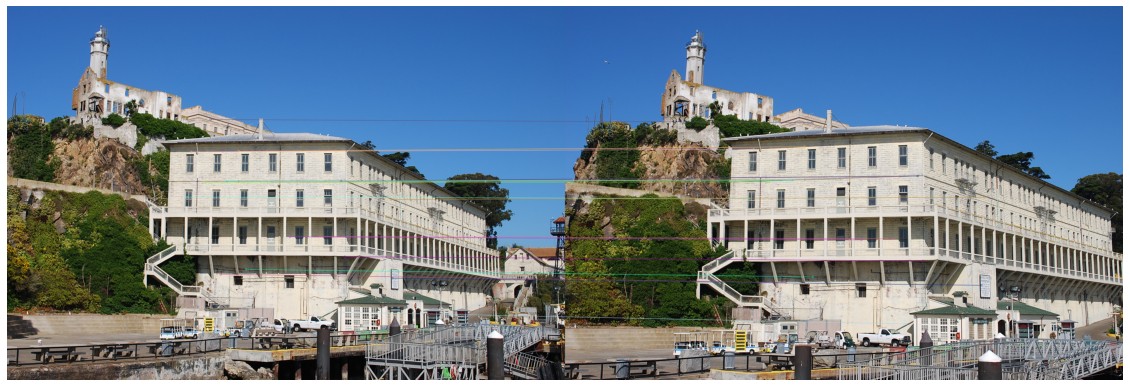

In [20]:
img1_2_matches = cv.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20, 10))
plt.imshow(img1_2_matches[:,:,::-1])
plt.axis('off')

In [21]:
n_matches = 1000
kp1_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
    kp1_array[0][i] = kp1[matches[i].queryIdx].pt[0]
    kp1_array[1][i] = kp1[matches[i].queryIdx].pt[1]
 
kp2_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
    kp2_array[0][i] = kp2[matches[i].trainIdx].pt[0]
    kp2_array[1][i] = kp2[matches[i].trainIdx].pt[1]

In [22]:
x1 = homography.make_homog(kp1_array)
x2 = homography.make_homog(kp2_array)

In [23]:
K = np.array([[2394,0,932], [0,2398,628], [0,0,1]])
P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])

In [24]:
x1n = np.dot(linalg.inv(K), x1)
x2n = np.dot(linalg.inv(K), x2)

In [25]:
#estimate E with RANSAC
model = sfm.RansacModel()
E, inliers = sfm.F_from_ransac(x1n, x2n, model)

In [26]:
#compute camera matrices (P2 will be list of four solutions)
P2_all = sfm.compute_P_from_essential(E)
#pick the solution with points in front of cameras
ind = 0
maxres = 0
for i in range(4):
    #triangulate inliers and compute depth for each camera
    X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2_all[i])
    d1 = np.dot(P1, X)[2]
    d2 = np.dot(P2_all[i], X)[2]
    s = sum(d1 > 0) + sum(d2 > 0)
    if s > maxres:
        maxres = s
        ind = i
        infront = (d1 > 0) & (d2 > 0)
P2 = P2_all[ind]

In [27]:
#triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)
X = X[:, infront]

In [28]:
print(len(X[0]))

836


C:\Users\shane\AppData\Local\Temp\ipykernel_17908\2147529719.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = "3d")


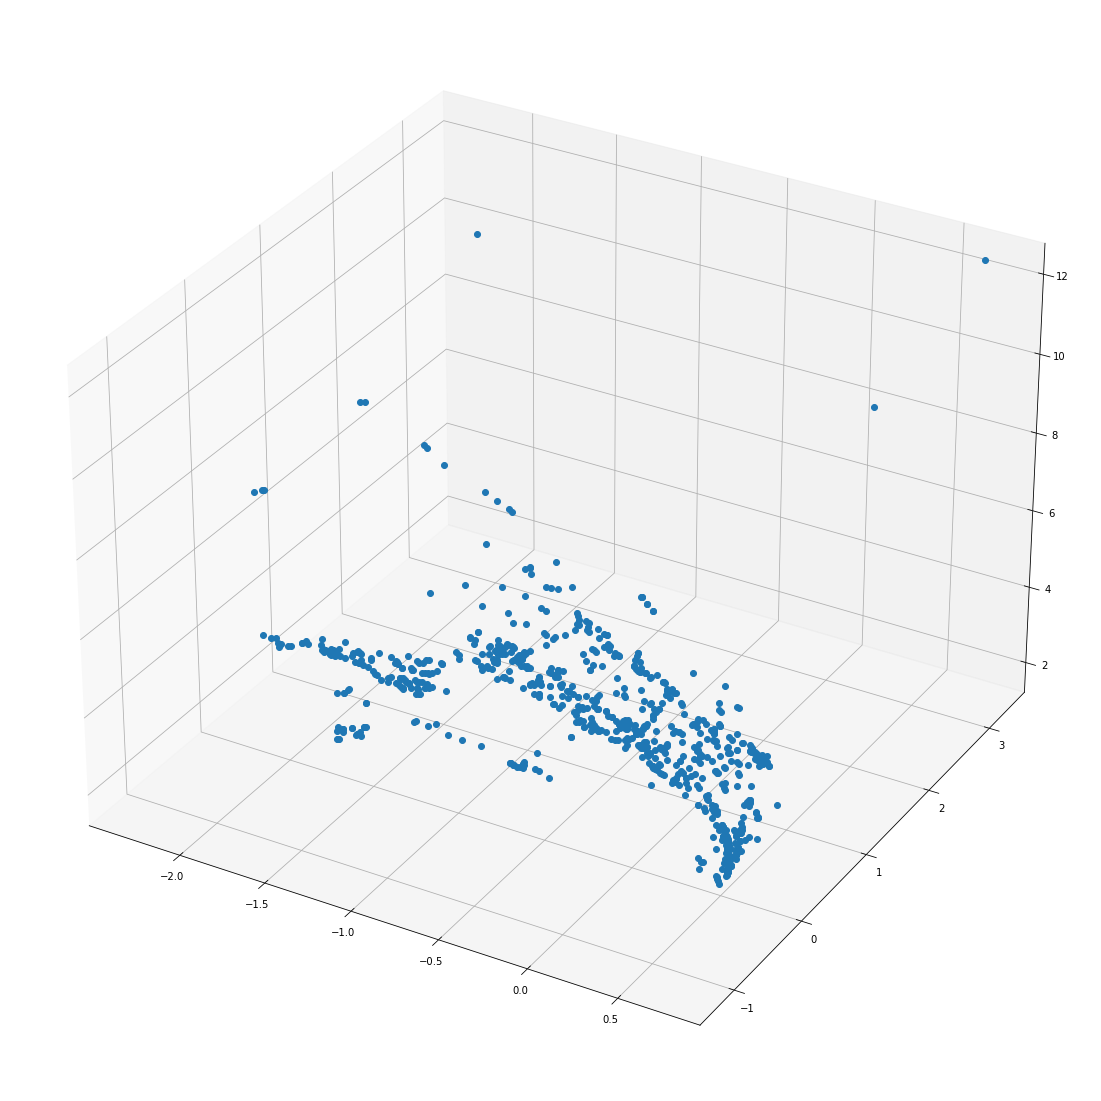

In [29]:
#3D plot
fig = plt.figure(figsize = [20,20])
ax = fig.gca(projection = "3d")
ax.view_init(elev = None, azim = None) #you can set elevation and azimuth with different values
ax.plot(X[0], X[1], X[2], 'o')
plt.draw()
plt.show()

---- 

In [30]:
xp2 = project(P2,X)
print(xp2)

[[-0.0221189  -0.26952637  0.09033844 ...  0.3277593  -0.13151606
  -0.30403469]
 [-0.00410005 -0.056219   -0.04490661 ...  0.07084878 -0.05988897
   0.17972378]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


In [31]:
p2x = np.dot(K,xp2)
print(p2x)

[[8.79047361e+02 2.86753868e+02 1.14827022e+03 ... 1.71665577e+03
  6.17150564e+02 2.04140956e+02]
 [6.18168073e+02 4.93186826e+02 5.20313955e+02 ... 7.97895385e+02
  4.84386239e+02 1.05897764e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


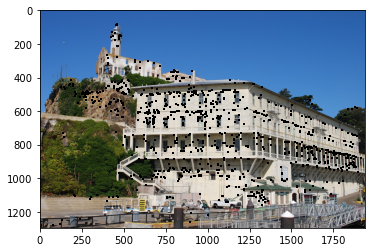

In [133]:
fig, ax = plt.subplots()
plt.imshow(img2[:,:,::-1])
item = 0
for p,q in zip(kp2_array[0],kp2_array[1]):
    x_cord = p 
    y_cord = q
    ax.scatter([x_cord], [y_cord],s=2,c='black',marker="+")
    item = item + 1
    if item == 1000:
        break
plt.show()

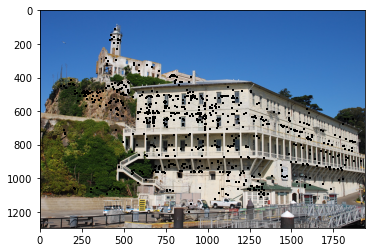

In [36]:
fig, ax = plt.subplots()
plt.imshow(img2[:,:,::-1])
item = 0
for p,q in zip(p2x[0],p2x[1]):
    x_cord = p 
    y_cord = q
    ax.scatter([x_cord], [y_cord],s=2,c='black',marker="+")
    item = item + 1
    if item == 1000:
        break
plt.show()